In [ ]:
from pathlib import Path
from drone_detector.tiling import *
from drone_detector.utils import *
import os, sys
import geopandas as gpd
import pandas as pd
import rasterio as rio
import math
from shapely.geometry import box
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
from shapely.geometry import Point 

def get_len(geom):
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_len)

# All data distributions

In [ ]:
data_path = Path('../data/hiidenportti/testresults/min_rot_rec_nms/')

In [ ]:
full_preds = None


vectors = [f for f in os.listdir(data_path/'predicted_vectors')]

for v in vectors:
    tempgdf = gpd.read_file(data_path/f'predicted_vectors/{v}')
    tempgdf['patch_id'] = f'{v}'
    if full_preds is None:
        full_preds = tempgdf
    else:
        full_preds = full_preds.append(tempgdf)
full_preds.reset_index(inplace=True, drop=True)

In [ ]:
full_truths = None


vectors = [f for f in os.listdir(data_path/'vector_tiles')]

for v in vectors:
    tempgdf = gpd.read_file(data_path/f'vector_tiles/{v}')
    tempgdf['patch_id'] = f'{v}'
    if full_truths is None:
        full_truths = tempgdf
    else:
        full_truths = full_truths.append(tempgdf)
full_truths.reset_index(inplace=True, drop=True)

Remove empty geometries that for some reason exist.

In [ ]:
full_preds.dropna(subset=['geometry'], inplace=True)
full_truths.dropna(subset=['geometry'], inplace=True)

In [ ]:
full_preds['layer'] = full_preds.apply(lambda row: 'uprightwood' if row.label == 1 else 'groundwood', axis=1)
#full_truths['layer'] = full_truths.apply(lambda row: 'uprightwood' if row.label == 1 else 'groundwood', axis=1)

Fix polygons so that they are not MultiPolygons and do not contain any holes.

In [ ]:
full_preds['geometry'] = full_preds.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                        else Polygon(row.geometry.exterior), axis=1)
full_truths['geometry'] = full_truths.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                        else Polygon(row.geometry.exterior), axis=1)

Get some information, assume that GSD is 0.04m. Depending on the mosaic it's really between 0.039m and 0.044m.

In [ ]:
def aspect_ratio(row):
    if row.bbox_x_px > row.bbox_y_px:
        return row.bbox_x_px / row.bbox_y_px
    else:
        return - (row.bbox_y_px) / (row.bbox_x_px)

In [ ]:
full_truths['area'] = full_truths.geometry.area

full_truths['pixel_area'] = full_truths.area / 0.04**2

full_truths['bbox_area'] = full_truths.apply(lambda row: box(*row.geometry.bounds).area, axis=1)

full_truths['bbox_x_px'] = full_truths.apply(lambda row: (row.geometry.bounds[2] - row.geometry.bounds[0]) / 0.04, axis=1)
full_truths['bbox_y_px'] = full_truths.apply(lambda row: (row.geometry.bounds[3] - row.geometry.bounds[1]) / 0.04, axis=1)

full_truths['bbox_pixel_area'] = full_truths.bbox_area / 0.04**2

full_truths['bbox_aspect_ratio'] = full_truths.bbox_x_px / full_truths.bbox_y_px

full_truths['coco_scale'] = full_truths.apply(lambda row: 'small' if row.pixel_area < 32**2 
                                          else ('large' if row.pixel_area > 96**2 else 'medium'), axis=1)

In [ ]:
full_preds['area'] = full_preds.geometry.area

full_preds['pixel_area'] = full_preds.area / 0.04**2

full_preds['bbox_area'] = full_preds.apply(lambda row: box(*row.geometry.bounds).area, axis=1)

full_preds['bbox_x_px'] = full_preds.apply(lambda row: (row.geometry.bounds[2] - row.geometry.bounds[0]) / 0.04, axis=1)
full_preds['bbox_y_px'] = full_preds.apply(lambda row: (row.geometry.bounds[3] - row.geometry.bounds[1]) / 0.04, axis=1)

full_preds['bbox_pixel_area'] = full_preds.bbox_area / 0.04**2

full_preds['bbox_aspect_ratio'] = full_preds.bbox_x_px / full_preds.bbox_y_px

full_preds['coco_scale'] = full_preds.apply(lambda row: 'small' if row.pixel_area < 32**2 
                                          else ('large' if row.pixel_area > 96**2 else 'medium'), axis=1)

COCO scales are divided by pixel area. `small` is less than $32^2$ pixels, `large` is more than $96^2$ pixels and `medium` is between them.

In [ ]:
pd.crosstab(full_truths.layer, full_truths.coco_scale, margins=True)

coco_scale,medium,small,All
layer,,,
groundwood,10,993,1003
uprightwood,86,23,109
All,96,1016,1112


In [ ]:
pd.crosstab(full_preds.layer, full_preds.coco_scale, margins=True)

coco_scale,medium,small,All
layer,,,
groundwood,9,1099,1108
uprightwood,55,10,65
All,64,1109,1173


As seen here, almost all of the annotated groundwood are considered `small`, while annotated uprightwood are mostly `medium`.

Area of different deadwood types, in m²

In [ ]:
pd.pivot_table(full_truths, index='layer', values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
layer,,,,
groundwood,0.059450,2.827265,0.426631,0.349878
uprightwood,0.353124,10.794837,3.430538,2.815479
All,0.059450,10.794837,0.721079,0.380515


In [ ]:
pd.pivot_table(full_preds, index='layer', values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
layer,,,,
groundwood,0.034621,2.971512,0.399203,0.321138
uprightwood,0.837303,10.852870,3.669362,3.077774
All,0.034621,10.852870,0.580413,0.333998


Text(0.5, 1.0, 'Predicted groundwood area (m²)')

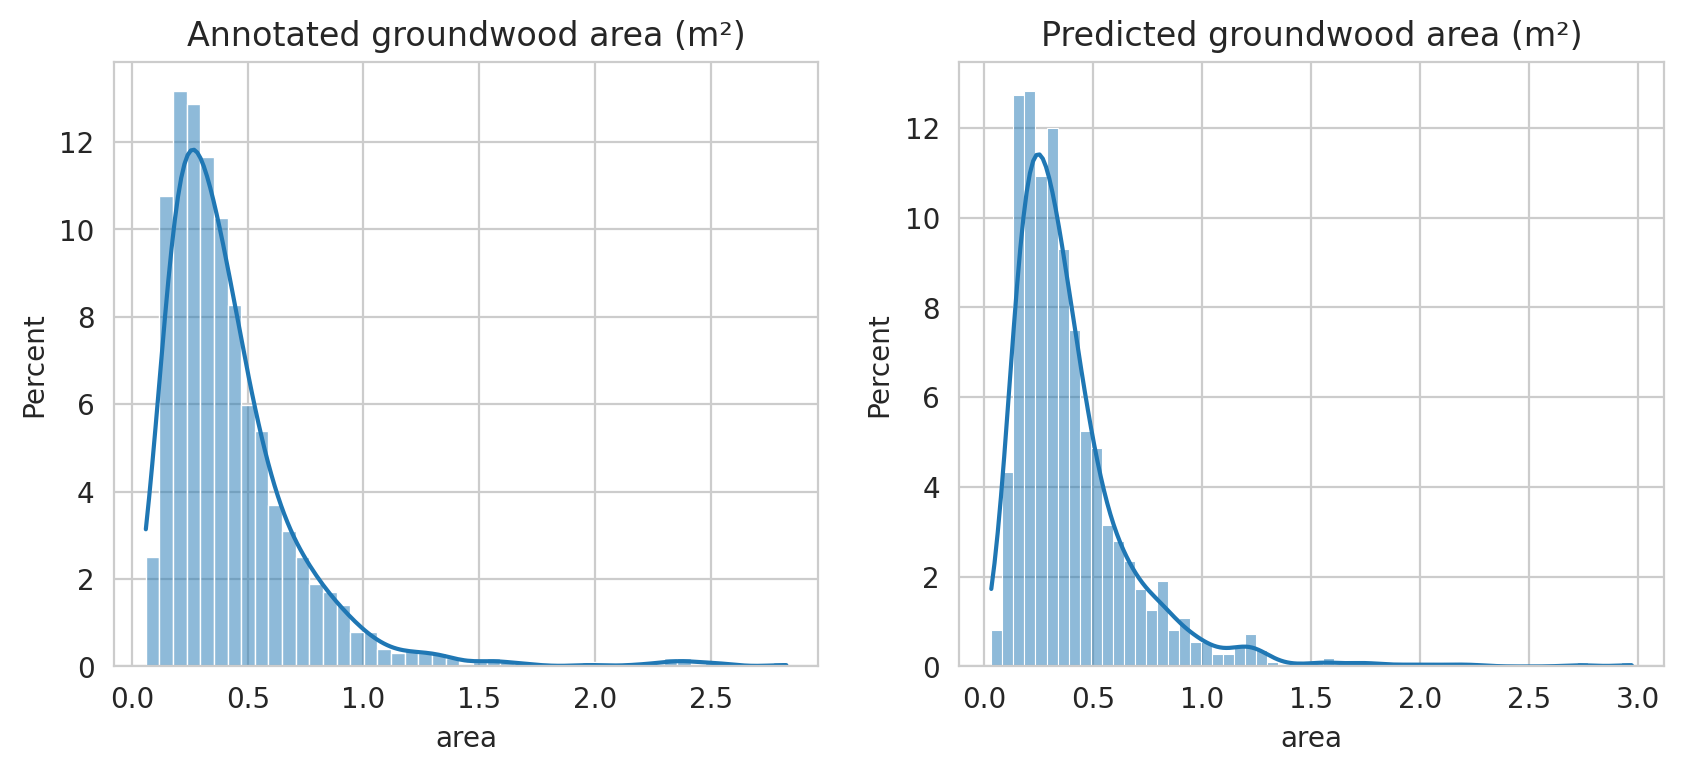

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='groundwood'], x='area', kde=True, stat='percent', ax=axs[0], log_scale=False)
axs[0].set_title('Annotated groundwood area (m²)')
sns.histplot(full_preds[full_preds.layer=='groundwood'], x='area', kde=True, stat='percent', ax=axs[1], log_scale=False)
axs[1].set_title('Predicted groundwood area (m²)')

Text(0.5, 1.0, 'Predicted standing deadwood area (m²)')

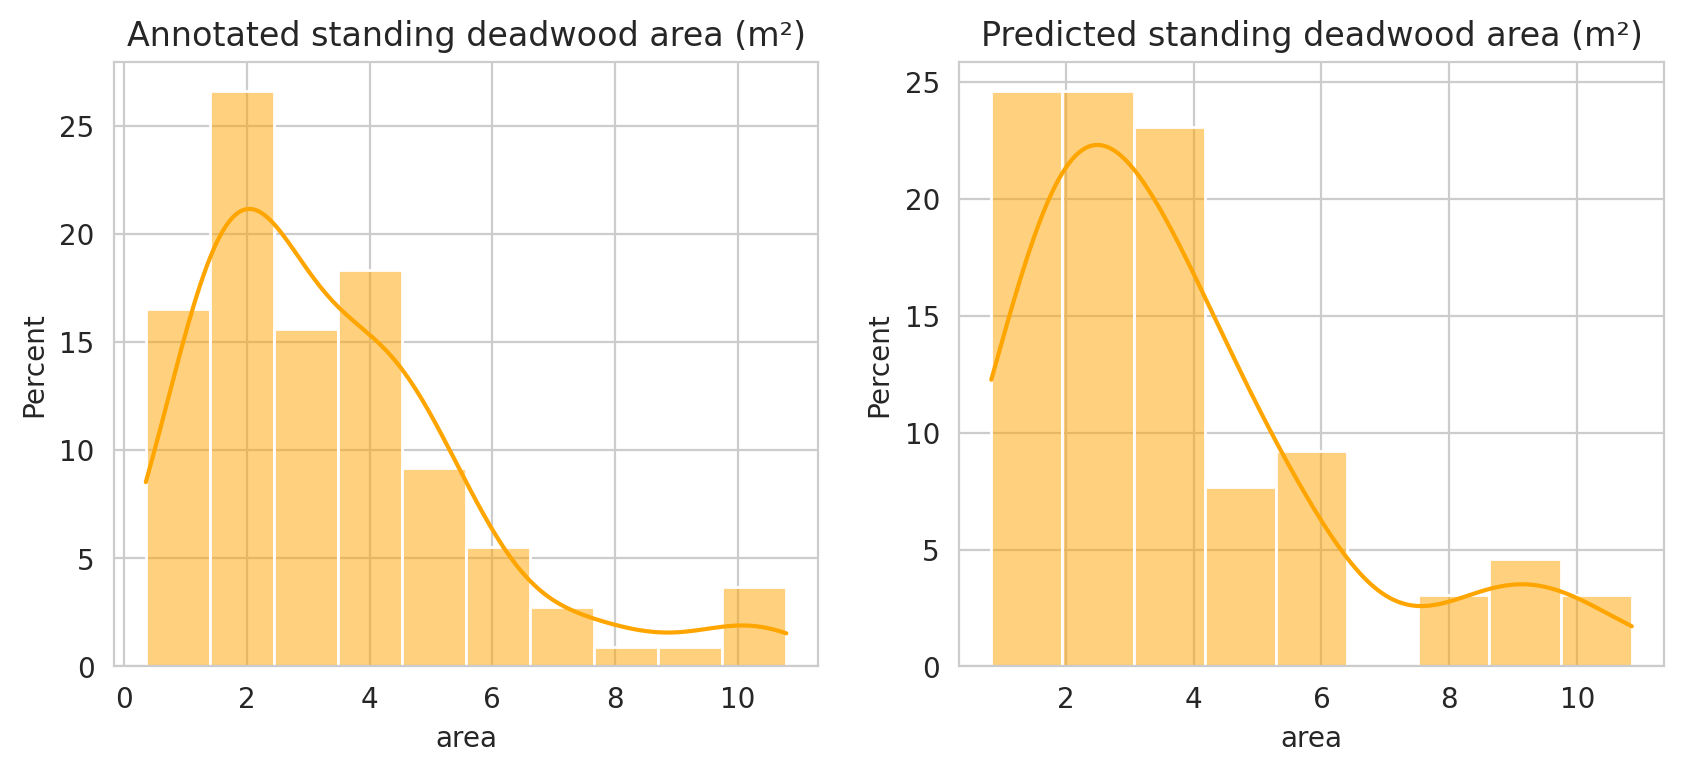

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='uprightwood'], x='area', kde=True, stat='percent', 
             ax=axs[0], log_scale=False, color='orange')
axs[0].set_title('Annotated standing deadwood area (m²)')
sns.histplot(full_preds[full_preds.layer=='uprightwood'], x='area', kde=True, stat='percent', 
             ax=axs[1], log_scale=False, color='orange')
axs[1].set_title('Predicted standing deadwood area (m²)')


Approximate area in pixels, average resolution around 0.04m so each pixel is 0.0016m²

In [ ]:
pd.pivot_table(full_truths, index='layer', values='pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,pixel_area,pixel_area,pixel_area,pixel_area
layer,,,,
groundwood,37.156387,1767.040663,266.644341,218.673931
uprightwood,220.702551,6746.773013,2144.086446,1759.674656
All,37.156387,6746.773013,450.674188,237.821894


In [ ]:
full_preds[full_preds.pixel_area < 40].layer.value_counts()

groundwood    9
Name: layer, dtype: int64

In [ ]:
pd.pivot_table(full_preds, index='layer', values='pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,pixel_area,pixel_area,pixel_area,pixel_area
layer,,,,
groundwood,21.638148,1857.194862,249.501635,200.711267
uprightwood,523.314644,6783.043924,2293.351098,1923.608835
All,21.638148,6783.043924,362.758425,208.748497


Text(0.5, 1.0, 'Predicted groundwood pixel area')

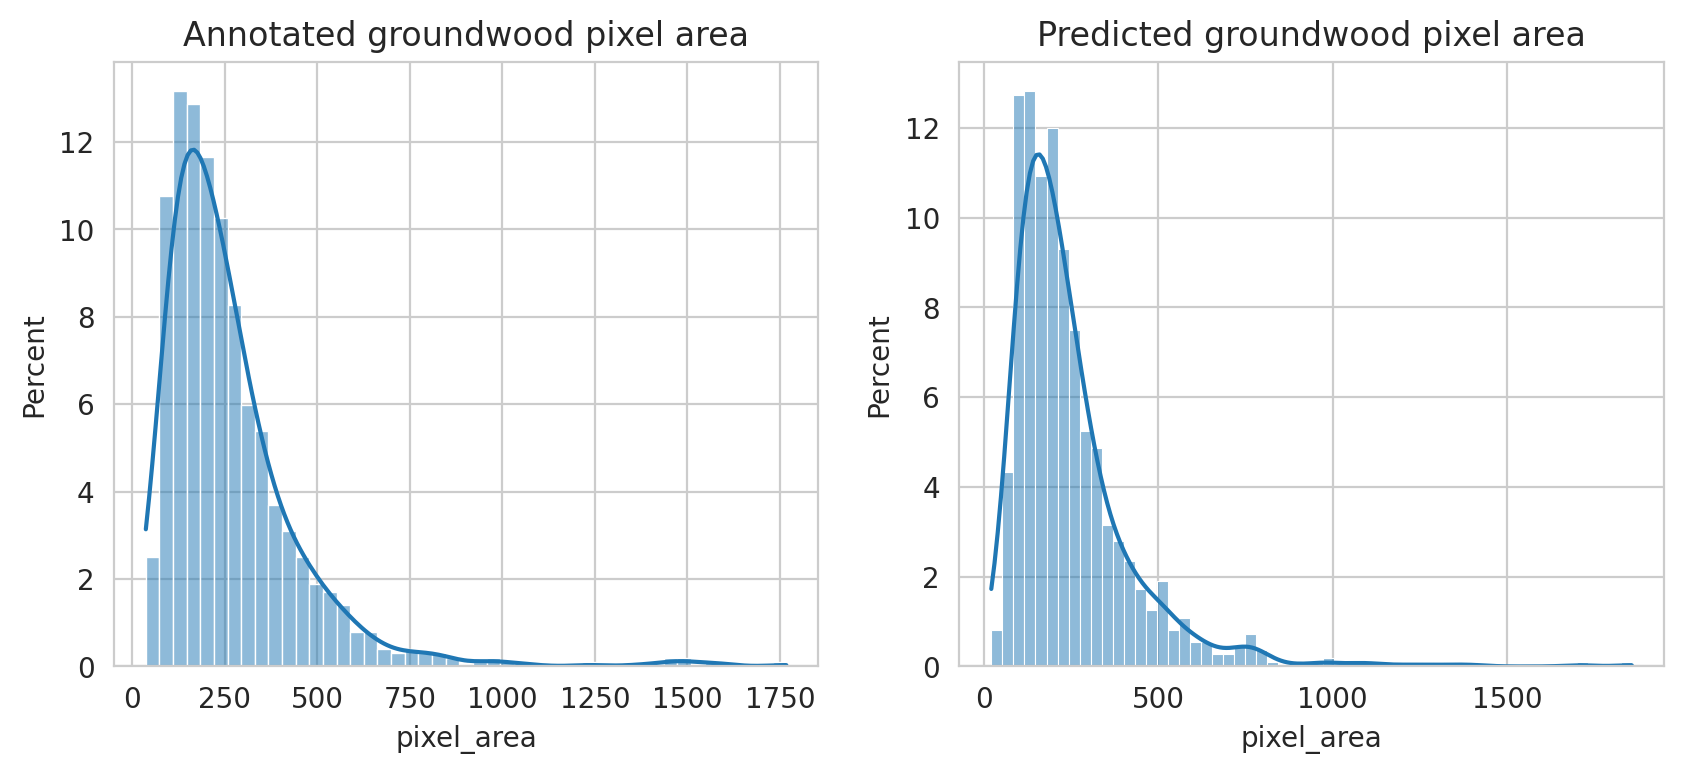

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='groundwood'], x='pixel_area', kde=True, stat='percent', ax=axs[0], log_scale=False)
axs[0].set_title('Annotated groundwood pixel area')
sns.histplot(full_preds[full_preds.layer=='groundwood'], x='pixel_area', kde=True, stat='percent', ax=axs[1], log_scale=False)
axs[1].set_title('Predicted groundwood pixel area')

Text(0.5, 1.0, 'Predicted standing deadwood pixel area')

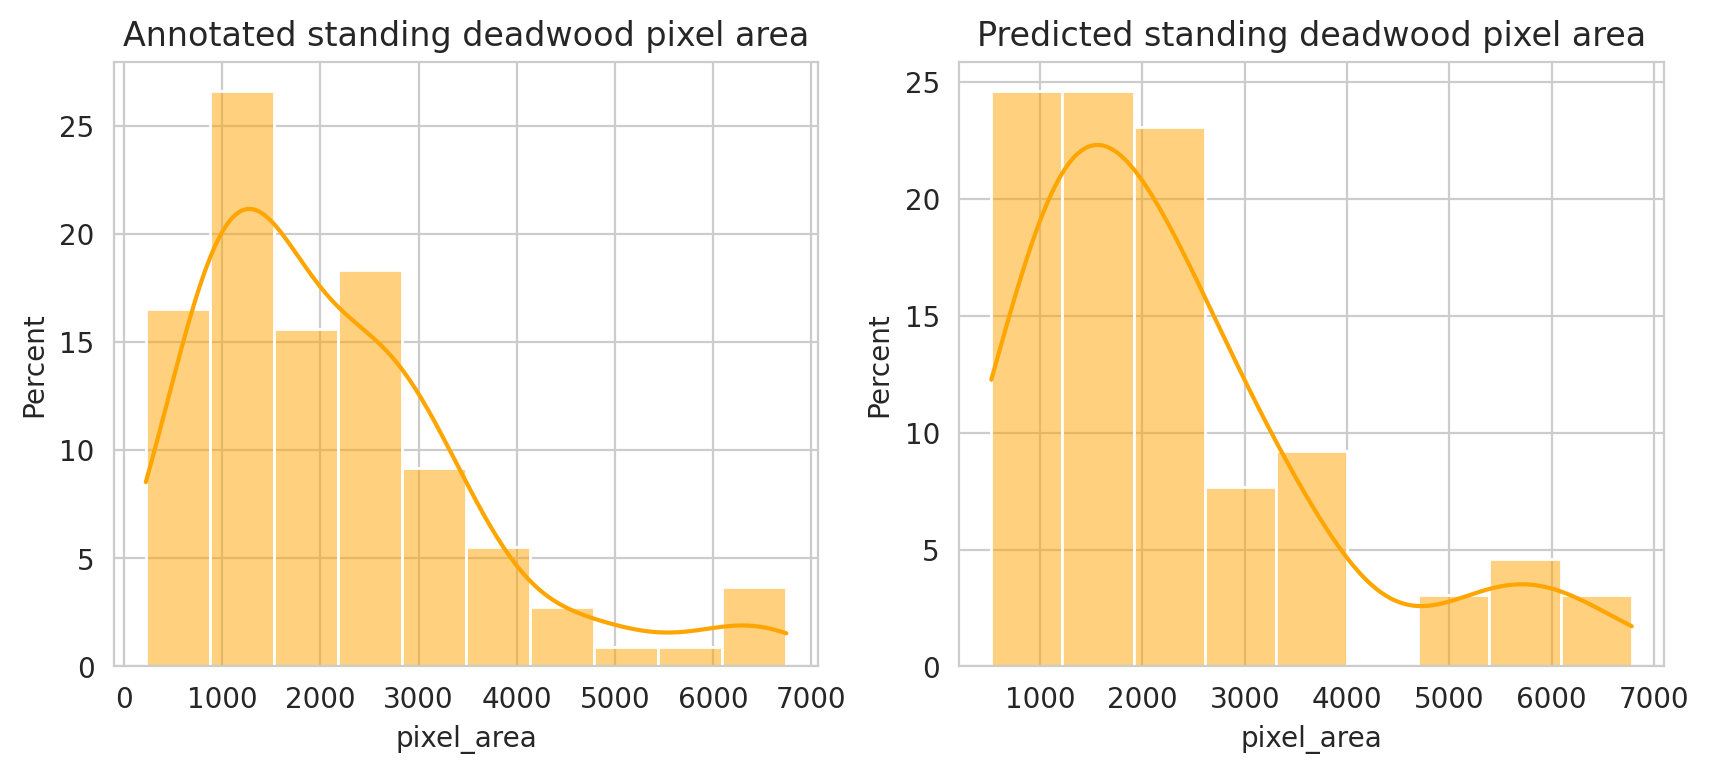

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='uprightwood'], x='pixel_area', kde=True, stat='percent', 
             ax=axs[0], log_scale=False, color='orange')
axs[0].set_title('Annotated standing deadwood pixel area')
sns.histplot(full_preds[full_preds.layer=='uprightwood'], x='pixel_area', kde=True, stat='percent', 
             ax=axs[1], log_scale=False, color='orange')
axs[1].set_title('Predicted standing deadwood pixel area')


Area of bounding boxes, in pixels.

In [ ]:
pd.pivot_table(full_truths, index='layer', values='bbox_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area
layer,,,,
groundwood,49.585925,32997.923035,1657.261747,895.593468
uprightwood,316.718162,11833.487983,3695.566311,3022.991501
All,49.585925,32997.923035,1857.059587,1004.759601


In [ ]:
pd.pivot_table(full_preds, index='layer', values='bbox_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area
layer,,,,
groundwood,28.822907,22932.586763,1406.801598,795.602562
uprightwood,749.781091,9878.368693,3617.237945,2956.033494
All,28.822907,22932.586763,1529.289546,851.676088


Text(0.5, 1.0, 'Predicted groundwood bbox area')

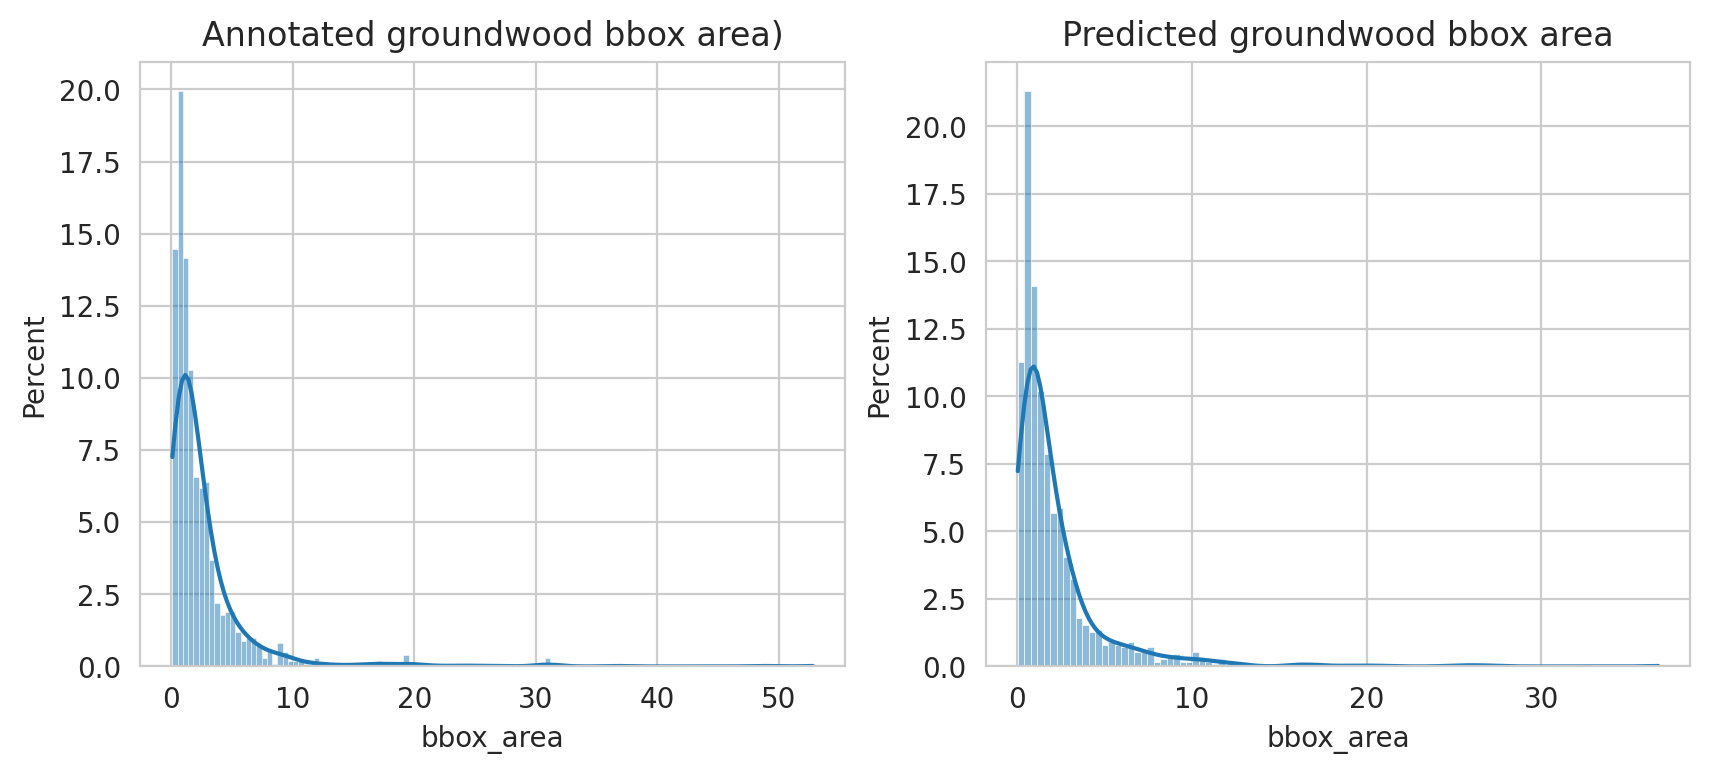

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='groundwood'], x='bbox_area', kde=True, stat='percent', ax=axs[0], log_scale=False)
axs[0].set_title('Annotated groundwood bbox area)')
sns.histplot(full_preds[full_preds.layer=='groundwood'], x='bbox_area', kde=True, stat='percent', ax=axs[1], log_scale=False)
axs[1].set_title('Predicted groundwood bbox area')

Text(0.5, 1.0, 'Predicted standing deadwood bbox area')

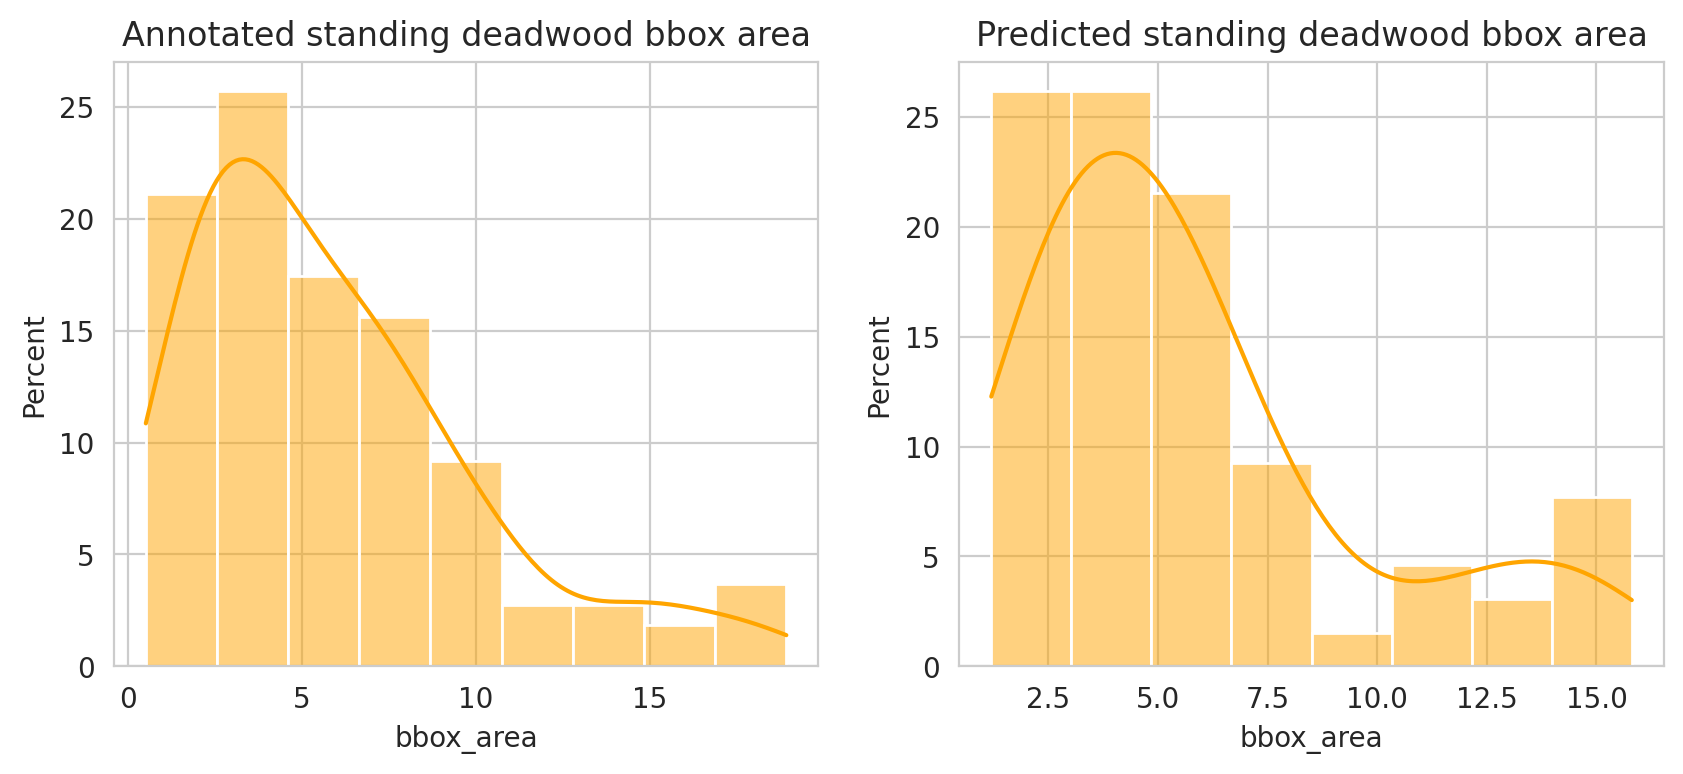

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='uprightwood'], x='bbox_area', kde=True, stat='percent', 
             ax=axs[0], log_scale=False, color='orange')
axs[0].set_title('Annotated standing deadwood bbox area')
sns.histplot(full_preds[full_preds.layer=='uprightwood'], x='bbox_area', kde=True, stat='percent', 
             ax=axs[1], log_scale=False, color='orange')
axs[1].set_title('Predicted standing deadwood bbox area')


Aspect (width / height) ratios of bounding boxes. For reference, default ratios for Mask R-CNN are 0.5, 1, 2 so region proporsals are in 1:2, 1:1 or 2:1 ratio. Here aspect ratios for boxes with height > width are presented as negative.

In [ ]:
pd.pivot_table(full_truths, index='layer', values='bbox_aspect_ratio', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio
layer,,,,
groundwood,0.059465,24.910023,1.771437,1.042077
uprightwood,0.684048,1.594406,1.061807,1.030012
All,0.059465,24.910023,1.701878,1.040538


In [ ]:
pd.pivot_table(full_preds, index='layer', values='bbox_aspect_ratio', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio
layer,,,,
groundwood,0.040000,28.800000,1.975181,1.186343
uprightwood,0.438596,1.785714,0.970723,0.945946
All,0.040000,28.800000,1.919520,1.129032


Text(0.5, 1.0, 'Predicted groundwood bbox aspect ratios')

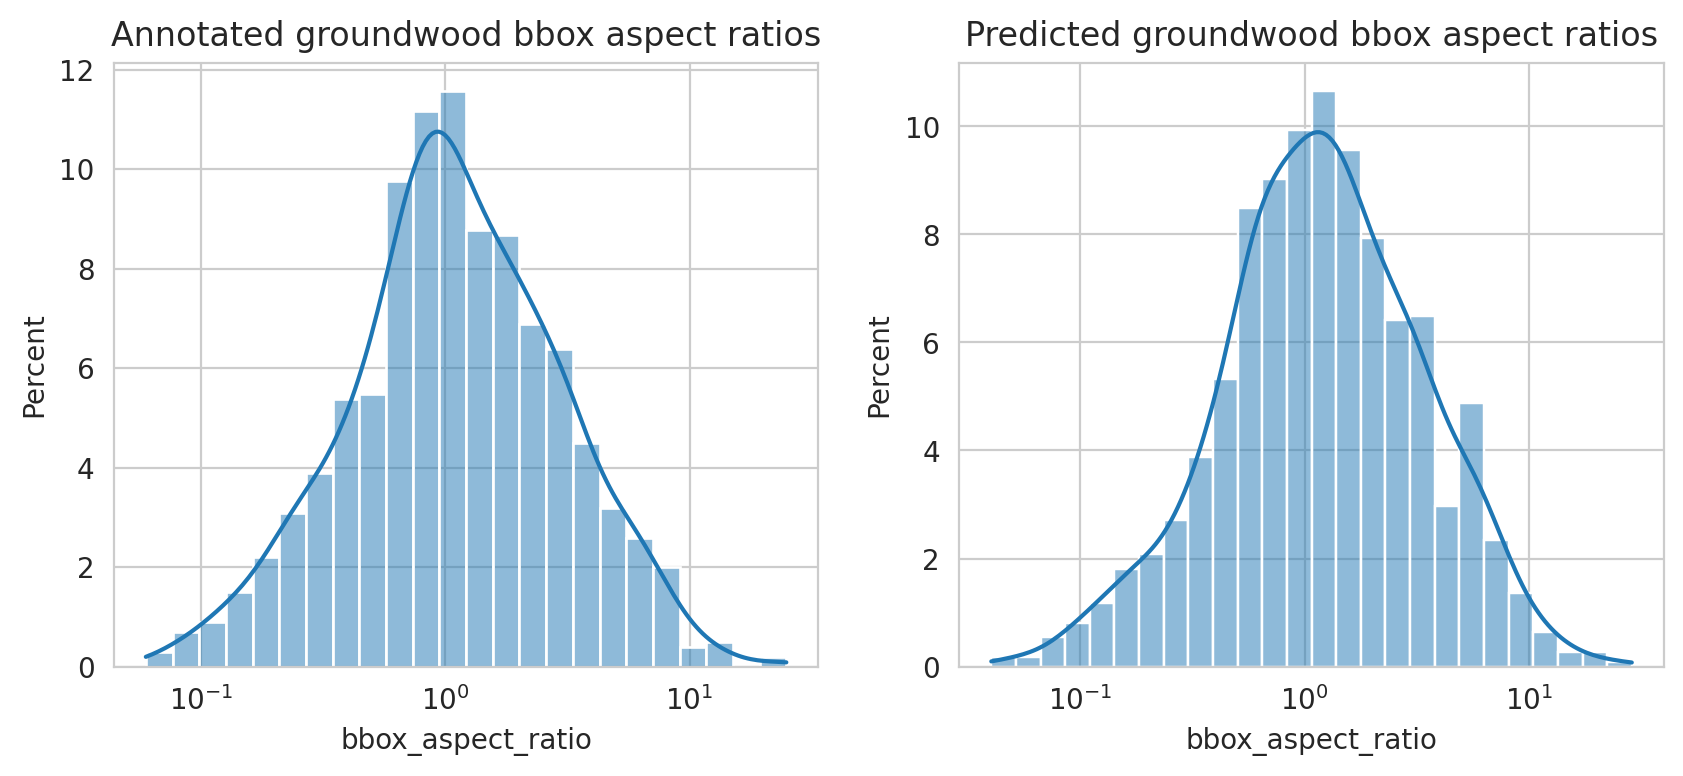

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='groundwood'], x='bbox_aspect_ratio', kde=True, stat='percent', 
             ax=axs[0], log_scale=True)
axs[0].set_title('Annotated groundwood bbox aspect ratios')
sns.histplot(full_preds[full_preds.layer=='groundwood'], x='bbox_aspect_ratio', kde=True, stat='percent', 
             ax=axs[1], log_scale=True)
axs[1].set_title('Predicted groundwood bbox aspect ratios')

Text(0.5, 1.0, 'Predicted standing deadwood bbox aspect ratio')

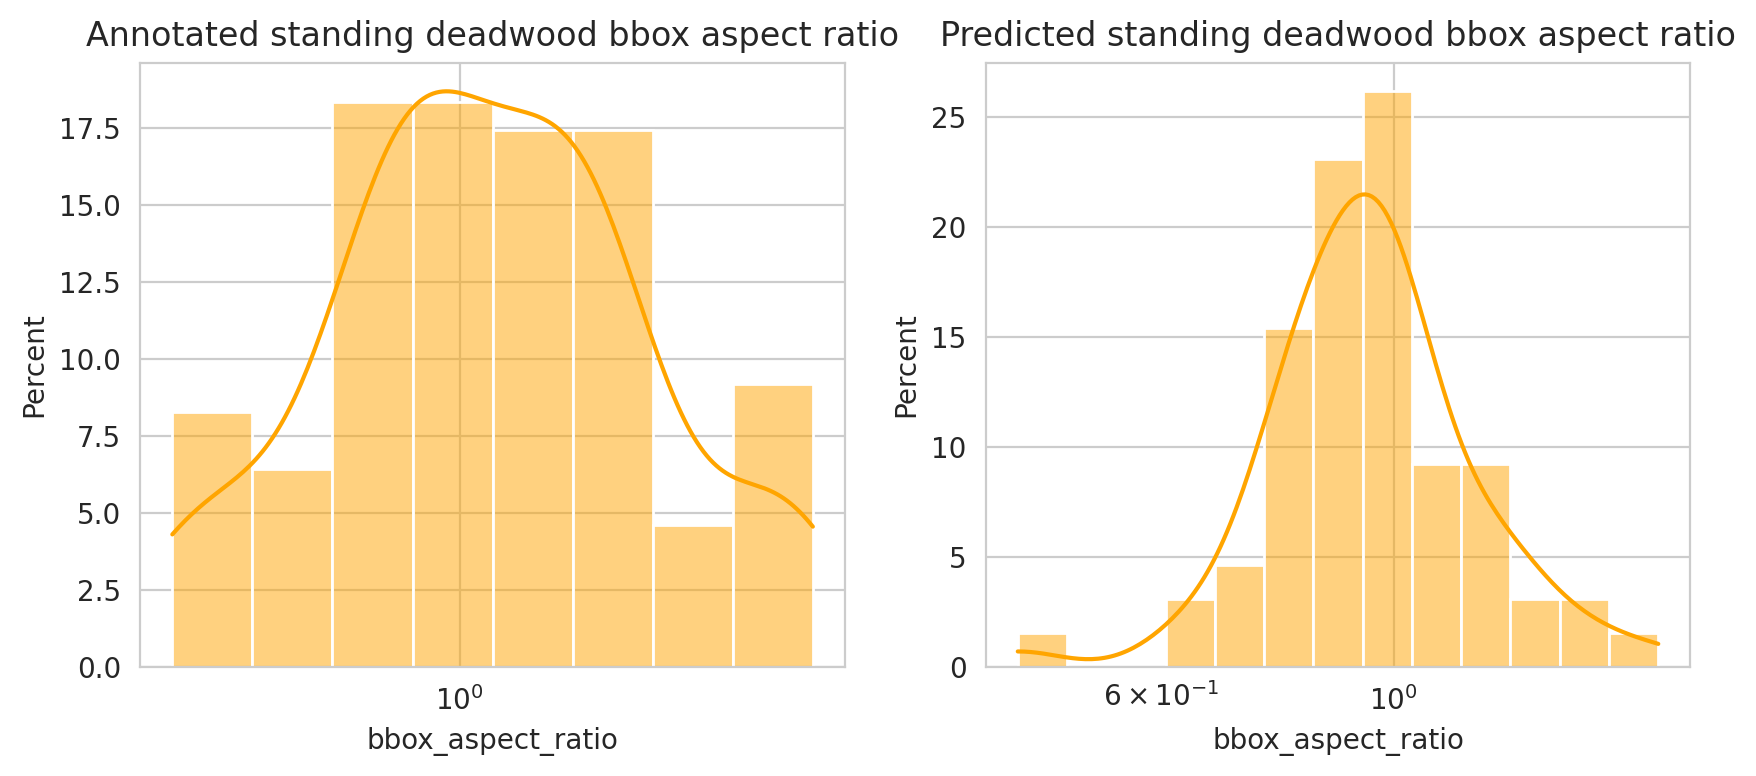

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='uprightwood'], x='bbox_aspect_ratio', kde=True, stat='percent', 
             ax=axs[0], log_scale=True, color='orange')
axs[0].set_title('Annotated standing deadwood bbox aspect ratio')
sns.histplot(full_preds[full_preds.layer=='uprightwood'], x='bbox_aspect_ratio', kde=True, stat='percent', 
             ax=axs[1], log_scale=True, color='orange')
axs[1].set_title('Predicted standing deadwood bbox aspect ratio')


As expected, groundwood has weird aspect ratios.

Length (groundwood) and maximum canopy radius (uprightwood) of the annotated polygons

In [ ]:
full_truths['tree_length'] = full_truths.apply(lambda row: get_len(row.geometry), axis=1)

In [ ]:
full_preds['tree_length'] = full_preds.apply(lambda row: get_len(row.geometry), axis=1)

In [ ]:
pd.pivot_table(full_truths, index='layer', values='tree_length', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,tree_length,tree_length,tree_length,tree_length
layer,,,,
groundwood,0.415480,11.243139,2.337976,2.010082
uprightwood,0.716593,4.849274,2.435740,2.330503
All,0.415480,11.243139,2.347559,2.048650


In [ ]:
pd.pivot_table(full_preds, index='layer', values='tree_length', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,tree_length,tree_length,tree_length,tree_length
layer,,,,
groundwood,0.216327,10.749797,2.232494,1.910369
uprightwood,1.138280,4.406566,2.474304,2.394863
All,0.216327,10.749797,2.245893,1.944602


Text(0.5, 1.0, 'Predicted groundwood trunk length in meters')

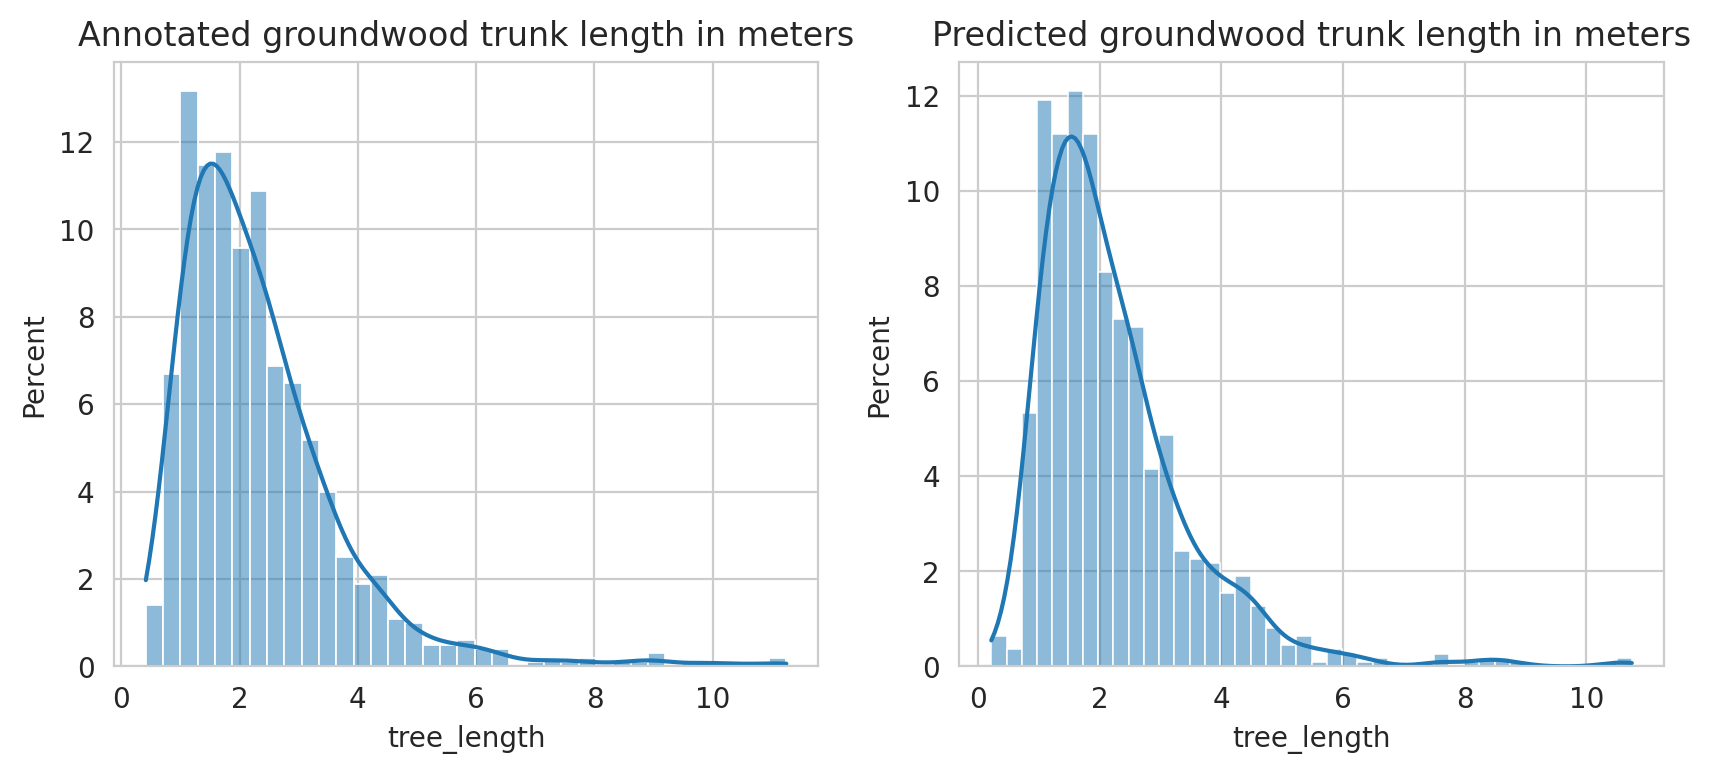

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='groundwood'], x='tree_length', kde=True, 
             stat='percent', ax=axs[0], log_scale=False, bins='auto')
axs[0].set_title('Annotated groundwood trunk length in meters')
sns.histplot(full_preds[full_preds.layer=='groundwood'], x='tree_length', kde=True, 
             stat='percent', ax=axs[1], log_scale=False, bins='auto')
axs[1].set_title('Predicted groundwood trunk length in meters')

In [ ]:
full_truths[full_truths.layer=='groundwood'].tree_length.sum()

2344.989583975136

In [ ]:
full_preds[full_preds.layer=='groundwood'].tree_length.sum()

2473.60291086065

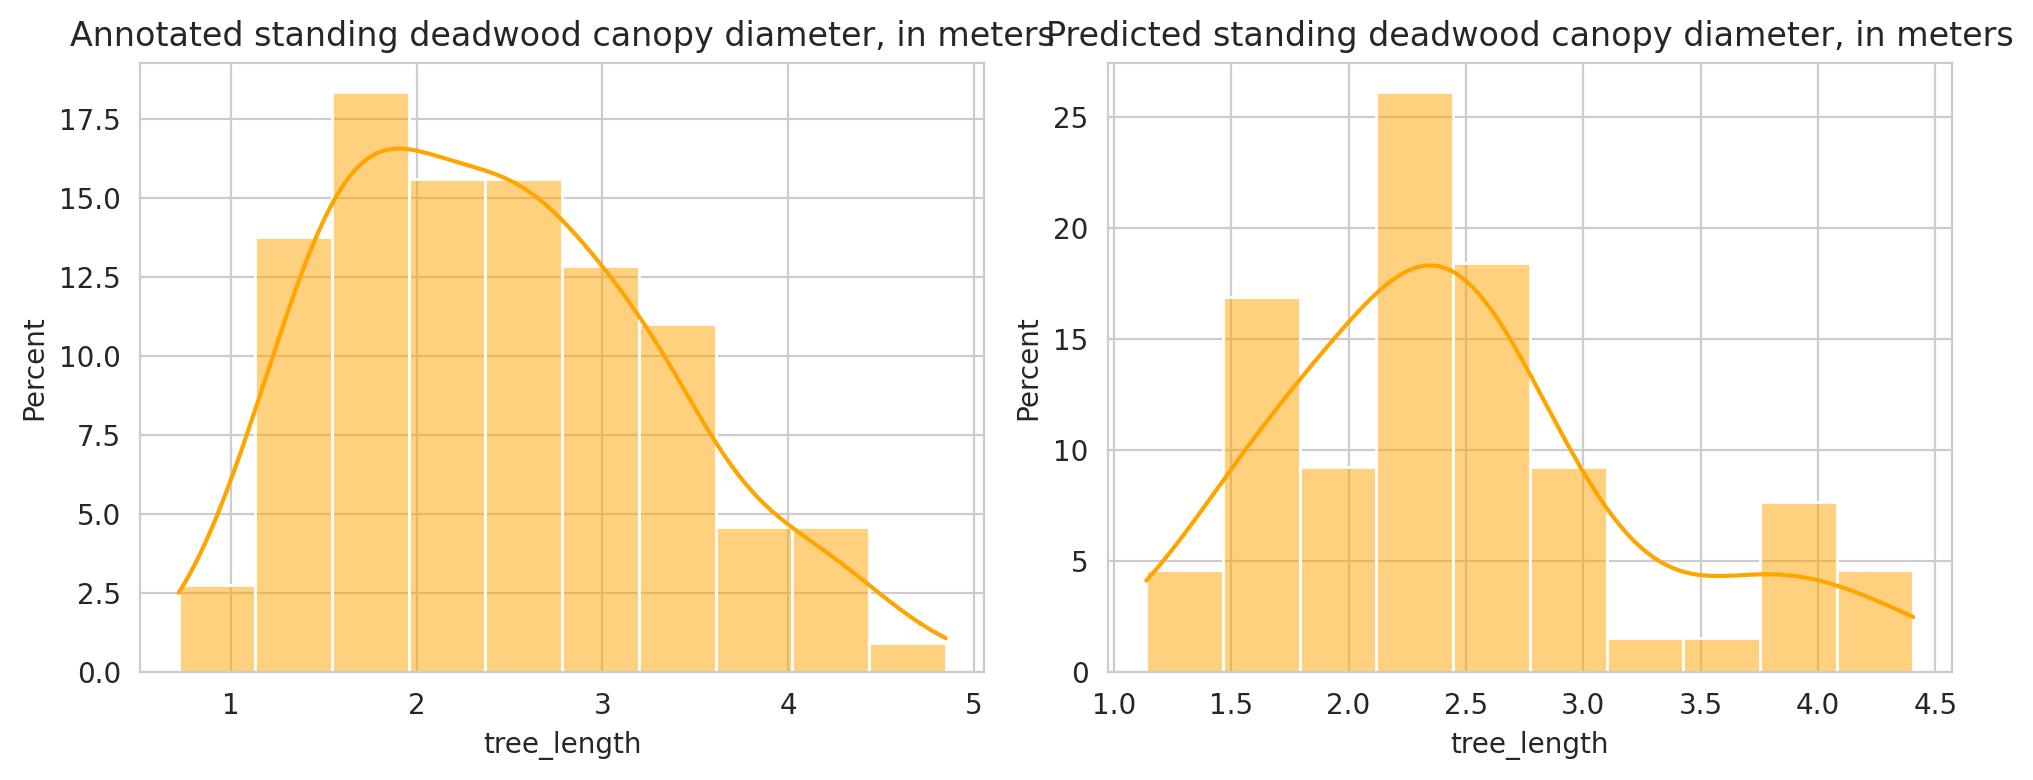

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4), dpi=200)
sns.histplot(full_truths[full_truths.layer=='uprightwood'], x='tree_length', kde=True, stat='percent', 
             ax=axs[0], log_scale=False, color='orange', bins=10)
axs[0].set_title('Annotated standing deadwood canopy diameter, in meters')
sns.histplot(full_preds[full_preds.layer=='uprightwood'], x='tree_length', kde=True, stat='percent', 
             ax=axs[1], log_scale=False, color='orange', bins=10)
axs[1].set_title('Predicted standing deadwood canopy diameter, in meters')
plt.tight_layout()